In [1]:
%matplotlib inline
import scipy
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# custom libraries used
from models.grid_world import Experiment
from models.agents import IndependentClusterAgent, JointClusteringAgent, FlatAgent
from models.experiment_designs.experiment1 import gen_task_param
sns.set_context('paper', font_scale=1.5)

In [2]:
n_sims = 115

# alpha is sample from the distribution
# log(alpha) ~ N(alpha_mu, alpha_scale)
alpha_mu = 0.0
alpha_scale = 1.0

inv_temp = 2.5
goal_prior = 10e-20 
prunning_threshold = 10.0
evaluate = True

np.random.seed(11223344)

# pre generate a set of tasks for consistency. 
list_tasks = [gen_task_param() for _ in range(n_sims)]

# pre draw the alphas for consistency
list_alpha = [np.exp(scipy.random.normal(loc=alpha_mu, scale=alpha_scale)) 
              for _ in range(n_sims)]

def sim_agent(AgentClass, name='None',flat=False):
    results = []
    for ii, (task_args, task_kwargs) in tqdm(enumerate(list_tasks), total=len(list_tasks)):

        if not flat:
            agent_kwargs = dict(alpha=list_alpha[ii], inv_temp=inv_temp, 
                                goal_prior=goal_prior)
        else:
            agent_kwargs = dict(inv_temp=inv_temp, goal_prior=goal_prior)
        
        agent = AgentClass(Experiment(*task_args, **task_kwargs), **agent_kwargs)
        
        _res = agent.generate(evaluate=evaluate, prunning_threshold=prunning_threshold)
        _res[u'Model'] = name
        _res[u'Iteration'] = [ii] * len(_res)
        results.append(_res)
    return pd.concat(results)

In [3]:
results_ic = sim_agent(IndependentClusterAgent, name='Independent')
results_jc = sim_agent(JointClusteringAgent, name='Joint')
results_fl = sim_agent(FlatAgent, name='Flat', flat=True)
results = pd.concat([results_ic, results_jc, results_fl])

HBox(children=(IntProgress(value=0), HTML(value=u'')))

HBox(children=(IntProgress(value=0), HTML(value=u'')))

HBox(children=(IntProgress(value=0), HTML(value=u'')))

## Model Predictions
Summary Statistics:

In [4]:
results['Training'] = results.Context < 5
results['Acc'] = pd.to_numeric(results.Reward)
results[results['In Goal']].groupby(['Training', 'Model']).mean()

Context  Goal KL Divergence  In Goal  Key-press  \
Training Model                                                           
False    Flat         6.166667            0.468281     True   3.506000   
         Independent  6.166667            1.661428     True   3.474333   
         Joint        6.166667            1.600524     True   3.504000   
True     Flat         2.750000            0.184373     True   3.504667   
         Independent  2.750000            0.547331     True   3.512833   
         Joint        2.750000            0.563621     True   3.512167   

                      Map KL Divergence  Steps Taken  Times Seen Context  \
Training Model                                                             
False    Flat                  0.754247     9.938000            4.666667   
         Independent           0.201908     7.650000            4.666667   
         Joint                 0.424904     8.630667            4.666667   
True     Flat                  0.243220     7.372250           16.333333   
         Independent           0.163467     7.260500           16.333333   
         Joint                 0.180621     7.198417           16.333333   

                      Trial Number  Iteration       Acc  
Training Model                                           
False    Flat                134.5       49.5  0.854333  
         Independent         134.5       49.5  0.807000  
         Joint               134.5       49.5  0.818667  
True     Flat                 59.5       49.5  0.953750  
         Independent          59.5       49.5  0.917917  
         Joint                59.5       49.5  0.941167

Plot the overall rewards collected in the training and test contexts

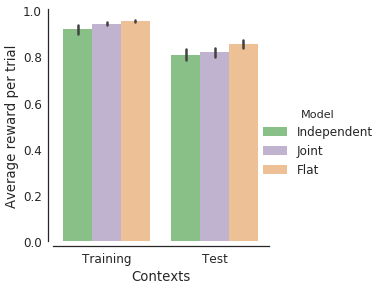

In [5]:
in_goal = results[results['In Goal'] ].copy()
in_goal['Contexts'] = [None] * len(in_goal)
in_goal.loc[in_goal.Context < 5, 'Contexts'] = 'Training'
in_goal.loc[in_goal.Context >= 5, 'Contexts'] = 'Test'

with sns.axes_style('white'):
    g = sns.factorplot(y='Reward', data=in_goal, x='Contexts', 
                   hue='Model', units='Iteration', kind='bar', 
                   estimator=np.mean, palette='Accent', size=4)
    sns.despine(offset=5, trim=False)
    ax = g.axes[0][0]
    ax.set_ylabel('Average reward per trial')

Break down the accuracy in each test context

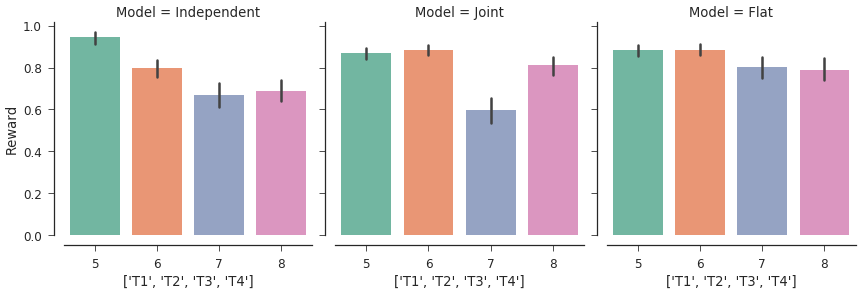

In [6]:
with sns.axes_style('ticks'):
    g = sns.factorplot(x='Context', y='Reward', data=in_goal[in_goal['Contexts'] == 'Test'], 
                   kind='bar', palette='Set2', col='Model', units='Iteration')
    g.set_xticklabels(['T1', 'T2', 'T3', 'T4'])
    sns.despine(offset=10)
    

# Paper Figure
*Left*: Reward collected in test contexts across time

*Right*: Difference in reward collect between contexts across equated trials

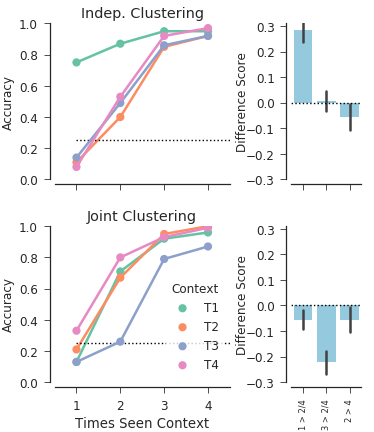

In [7]:
from matplotlib import gridspec

# plot the difference scores
df0 = results[results['In Goal'] & (results.Context > 4) & (results['Times Seen Context'] <= 4) &
              (results['Model'] != 'Flat')
             ].copy()

score = list()
for m in set(df0.Model):
    for it in set(df0.Iteration):
        subj_df = df0.loc[(df0.Model == m) & (df0.Iteration == it), :]
                
        diff_1 = subj_df.loc[subj_df.Context == 5, :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 6) | (subj_df.Context == 8), :].groupby('Times Seen Context').mean()['Acc']

        diff_2 = subj_df.loc[(subj_df.Context == 7), :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 6) | (subj_df.Context == 8), :].groupby('Times Seen Context').mean()['Acc']

        diff_3 = subj_df.loc[subj_df.Context == 6, :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 8), :].groupby('Times Seen Context').mean()['Acc']

        n = len(diff_1)
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T1 vs T2/4'] * n,
                    'Difference Score': diff_1,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T3 vs T2/4'] * n,
                    'Difference Score': diff_2,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T2 vs T4'] * n,
                    'Difference Score': diff_3,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
score = pd.concat(score) 

df0 = results[results['In Goal'] & (results.Context >= 5) & 
              (results['Times Seen Context'] < 5) ].copy()
df0['Context'] += 1

with sns.axes_style('ticks'):
    fig  = plt.figure(figsize=(5.5, 6.6))
    gs = gridspec.GridSpec(2, 2, width_ratios=[2.5, 1], wspace=0.5, hspace=0.3)
    axes = [
        [plt.subplot(gs[0]), plt.subplot(gs[1])],
        [plt.subplot(gs[2]),  plt.subplot(gs[3])]
    ]
    
    sns.pointplot(x = 'Times Seen Context', hue='Context', y='Reward', ci=None,
                   data=df0[df0.Model=='Independent'],  palette='Set2', ax=axes[0][0])
    sns.pointplot(x = 'Times Seen Context', hue='Context', y='Reward', ci=None,
                   data=df0[df0.Model=='Joint'],  palette='Set2', ax=axes[1][0])
    
    axes[0][0].legend_.remove() 
    ax = axes[1][0]
    handles, labels = ax.get_legend_handles_labels()
    handles[0].set_label('T1')
    handles[1].set_label('T2')
    handles[2].set_label('T3')
    handles[3].set_label('T4')
    legend = ax.legend(title="Context", loc='lower right', frameon=1)
    legend.get_frame().set_edgecolor('w')
    ax.get_legend().get_title().set_fontsize(12)
    
    
    # plot difference scores on the right
    sns.barplot(x='Comparison', y='Difference Score', 
            data=score[score.Model == 'Independent'], color='skyblue', ax=axes[0][1])
    sns.barplot(x='Comparison', y='Difference Score', #units='Iteration',
            data=score[score.Model == 'Joint'], color='skyblue', ax=axes[1][1])
    
    for ii in [0, 1]:
        ax = axes[ii][0]
        ax.set_ylabel(r'Accuracy',  fontdict={'size':12})
        ax.plot([0, 5], [0.25, 0.25], 'k:')
        ax.set_ylim([0, 1])
    
    sns.despine(offset=5)

    for ii in [0, 1]:
        ax = axes[ii][1]
        ax.set_ylabel(r'Difference Score', labelpad=-3, fontdict={'size':12})
        ax.set_xlabel('')
        ax.plot([-1, 3], [0, 0], 'k:')
        ax.set_ylim([-0.3, 0.31])
        ax.set_yticks(np.arange(-0.3, 0.31, 0.1))
        plt.sca(ax)
        plt.xticks([0, 1, 2], [r'1 > 2/4', u'3 > 2/4', r'2 > 4' ], rotation='vertical',
                  fontsize='small')
    plt.sca(axes[0][1])
    axes[0][1].set_xticklabels('')
    axes[0][0].set_xlabel('')
    axes[0][0].set_xticklabels('')
    axes[1][0].set_xticklabels([1, 2, 3, 4])
    
    axes[0][0].set_title('Indep. Clustering')
    axes[1][0].set_title('Joint Clustering')

    plt.savefig('Exp1_fig1.png', dpi=300, bbox_inches='tight')

In [8]:
from matplotlib import gridspec

# plot the difference scores
df0 = results[results['In Goal'] & (results.Context > 4) & (results['Times Seen Context'] <= 4) &
              (results['Model'] != 'Flat')
             ].copy()

score = list()
for m in set(df0.Model):
    for it in set(df0.Iteration):
        subj_df = df0.loc[(df0.Model == m) & (df0.Iteration == it), :]
                
        diff_1 = subj_df.loc[subj_df.Context == 5, :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 6) | (subj_df.Context == 8), :].groupby('Times Seen Context').mean()['Acc']

        diff_2 = subj_df.loc[(subj_df.Context == 7), :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 6) | (subj_df.Context == 8), :].groupby('Times Seen Context').mean()['Acc']

        diff_3 = subj_df.loc[subj_df.Context == 6, :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 8), :].groupby('Times Seen Context').mean()['Acc']

        n = len(diff_1)
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T1 vs T2/4'] * n,
                    'Difference Score': diff_1,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T3 vs T2/4'] * n,
                    'Difference Score': diff_2,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T2 vs T4'] * n,
                    'Difference Score': diff_3,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
score = pd.concat(score) 

df0 = results[results['In Goal'] & (results.Context >= 5) & 
              (results['Times Seen Context'] < 5) ].copy()
df0['Context'] += 1



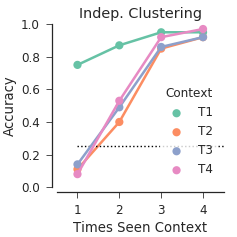

In [9]:
with sns.axes_style('ticks'):
    fig, ax  = plt.subplots(figsize=(3, 3))
    
    sns.pointplot(x = 'Times Seen Context', hue='Context', y='Reward', ci=None,
                   data=df0[df0.Model=='Independent'],  palette='Set2', ax=ax)
    ax.set_ylabel(r'Accuracy')
    ax.plot([0, 5], [0.25, 0.25], 'k:')
    ax.set_ylim([0, 1])
    ax.set_xticklabels([1, 2, 3, 4])
    ax.set_title('Indep. Clustering')
    
    ax.legend_.remove() 
    handles, labels = ax.get_legend_handles_labels()
    handles[0].set_label('T1')
    handles[1].set_label('T2')
    handles[2].set_label('T3')
    handles[3].set_label('T4')
    legend = ax.legend(title="Context", loc='lower right', frameon=1)
    legend.get_frame().set_edgecolor('w')
    ax.get_legend().get_title().set_fontsize(12)
    
    sns.despine(offset=5)

    plt.savefig('Exp1_fig1a.png', dpi=300, bbox_inches='tight')

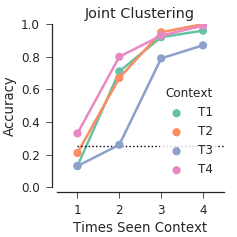

In [10]:
with sns.axes_style('ticks'):
    fig, ax  = plt.subplots(figsize=(3, 3))
    
    sns.pointplot(x = 'Times Seen Context', hue='Context', y='Reward', ci=None,
                   data=df0[df0.Model=='Joint'],  palette='Set2', ax=ax)
    ax.set_ylabel(r'Accuracy')
    ax.plot([0, 5], [0.25, 0.25], 'k:')
    ax.set_ylim([0, 1])
    ax.set_xticklabels([1, 2, 3, 4])
    ax.set_title('Joint Clustering')
    
    ax.legend_.remove() 
    handles, labels = ax.get_legend_handles_labels()
    handles[0].set_label('T1')
    handles[1].set_label('T2')
    handles[2].set_label('T3')
    handles[3].set_label('T4')
    legend = ax.legend(title="Context", loc='lower right', frameon=1)
    legend.get_frame().set_edgecolor('w')
    ax.get_legend().get_title().set_fontsize(12)
    
    sns.despine(offset=5)

    plt.savefig('Exp1_fig1b.png', dpi=300, bbox_inches='tight')

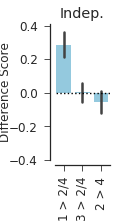

In [11]:
with sns.axes_style('ticks'):
    fig, ax  = plt.subplots(figsize=(1.0, 2.5))    # plot difference scores on the right
    sns.barplot(x='Comparison', y='Difference Score', units='Iteration',
            data=score[score.Model == 'Independent'], color='skyblue', ax=ax)
    ax.set_ylabel(r'Difference Score', labelpad=-3, fontdict={'size':12})
    ax.set_xlabel('')
    ax.plot([-1, 3], [0, 0], 'k:')
    ax.set_ylim([-0.3, 0.41])
    ax.set_yticks(np.arange(-0.4, 0.41, 0.2))
    sns.despine(offset=5)
    
    plt.xticks([0, 1, 2], [r'1 > 2/4', u'3 > 2/4', r'2 > 4' ], rotation='vertical')
#               fontsize='me')
    ax.set_title(r'Indep.')


    plt.savefig('Exp1_fig1d.png', dpi=300, bbox_inches='tight')

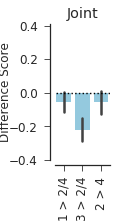

In [12]:
with sns.axes_style('ticks'):
    fig, ax  = plt.subplots(figsize=(1.0, 2.5))    # plot difference scores on the right
    sns.barplot(x='Comparison', y='Difference Score', units='Iteration',
            data=score[score.Model == 'Joint'], color='skyblue', ax=ax)
    ax.set_ylabel(r'Difference Score', labelpad=-3, fontdict={'size':12})
    ax.set_xlabel('')
    ax.plot([-1, 3], [0, 0], 'k:')
    ax.set_ylim([-0.3, 0.41])
    ax.set_yticks(np.arange(-0.4, 0.41, 0.2))
    sns.despine(offset=5)
    plt.xticks([0, 1, 2], [r'1 > 2/4', u'3 > 2/4', r'2 > 4' ], rotation='vertical')
    ax.set_title(r'Joint')

    

    plt.savefig('Exp1_fig1e.png', dpi=300, bbox_inches='tight')
    

# Meta Agent 

In [13]:
from models.agents import MetaAgent
results_meta = sim_agent(MetaAgent, name='Meta')
results_wMeta = pd.concat([results, results_meta])
results_wMeta['Acc'] = pd.to_numeric(results_wMeta.Reward)

HBox(children=(IntProgress(value=0), HTML(value=u'')))

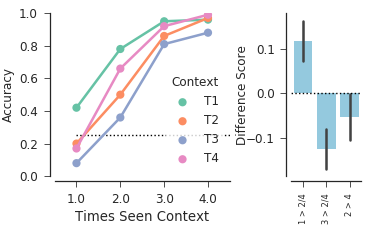

In [14]:
from matplotlib import gridspec

# plot the difference scores
df0 = results_wMeta[results_wMeta['In Goal'] & (results_wMeta.Context > 4) & 
                    (results_wMeta['Times Seen Context'] <= 4) &
                    (results_wMeta['Model'] != 'Flat')
                   ].copy()

score = list()
for m in set(df0.Model):
    for it in set(df0.Iteration):
        subj_df = df0.loc[(df0.Model == m) & (df0.Iteration == it), :]
                
        diff_1 = subj_df.loc[subj_df.Context == 5, :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 6) | (subj_df.Context == 8), :].groupby('Times Seen Context').mean()['Acc']

        diff_2 = subj_df.loc[(subj_df.Context == 7), :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 6) | (subj_df.Context == 8), :].groupby('Times Seen Context').mean()['Acc']

        diff_3 = subj_df.loc[subj_df.Context == 6, :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 8), :].groupby('Times Seen Context').mean()['Acc']

        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T1 vs T2/4'] * n,
                    'Difference Score': diff_1,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T3 vs T2/4'] * n,
                    'Difference Score': diff_2,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T2 vs T4'] * n,
                    'Difference Score': diff_3,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
            


score = pd.concat(score) 

df0 = results_wMeta[results_wMeta['In Goal'] & (results_wMeta.Context >= 5) &
                   (results_wMeta['Times Seen Context'] < 5)].copy()
df0['Context'] += 1

with sns.axes_style('ticks'):
    fig  = plt.figure(figsize=(5.5, 3))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2.5, 1], wspace=0.5, hspace=0.6)
    axes = [ plt.subplot(gs[0]), plt.subplot(gs[1])]
    
    sns.pointplot(x = 'Times Seen Context', hue='Context', y='Reward', ci=None,
                   data=df0[df0.Model=='Meta'],  palette='Set2', ax=axes[0])
    
    ax = axes[0]
    handles, labels = ax.get_legend_handles_labels()
    
    handles[0].set_label('T1')
    handles[1].set_label('T2')
    handles[2].set_label('T3')
    handles[3].set_label('T4')
    legend = ax.legend(title="Context", loc='lower right', frameon=1)
    legend.get_frame().set_edgecolor('w')
    ax.get_legend().get_title().set_fontsize(12)
    
    # plot difference scores on the right
    sns.barplot(x='Comparison', y='Difference Score', 
            data=score[score.Model == 'Meta'], color='skyblue', ax=axes[1])
    
    ax = axes[0]
    ax.set_ylabel(r'Accuracy',  fontdict={'size':12})
    ax.plot([0, 5], [0.25, 0.25], 'k:')
    ax.set_ylim([0, 1])
    
    sns.despine(offset=5)

    ax = axes[1]
    ax.set_ylabel(r'Difference Score', labelpad=-3, fontdict={'size':12})
    ax.set_xlabel('')
    ax.plot([-1, 3], [0, 0], 'k:')
    plt.sca(ax)
    plt.xticks([0, 1, 2], [r'1 > 2/4', u'3 > 2/4', r'2 > 4' ], rotation='vertical',
              fontsize='small')
    plt.savefig('Exp1_fig2.png', dpi=300)

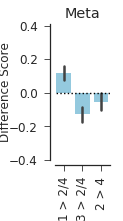

In [15]:
with sns.axes_style('ticks'):
    fig, ax  = plt.subplots(figsize=(1.0, 2.5))    # plot difference scores on the right
    sns.barplot(x='Comparison', y='Difference Score', 
            data=score[score.Model == 'Meta'], color='skyblue', ax=ax)
    ax.set_ylabel(r'Difference Score', labelpad=-3, fontdict={'size':12})
    ax.set_xlabel('')
    ax.plot([-1, 3], [0, 0], 'k:')
    ax.set_ylim([-0.3, 0.41])
    ax.set_yticks(np.arange(-0.4, 0.41, 0.2))
    sns.despine(offset=5)
    plt.xticks([0, 1, 2], [r'1 > 2/4', u'3 > 2/4', r'2 > 4' ], rotation='vertical')
    ax.set_title(r'Meta')

    plt.savefig('Exp1_fig1f.png', dpi=300, bbox_inches='tight')
    

Plot the evolution of the model responsibilities over time

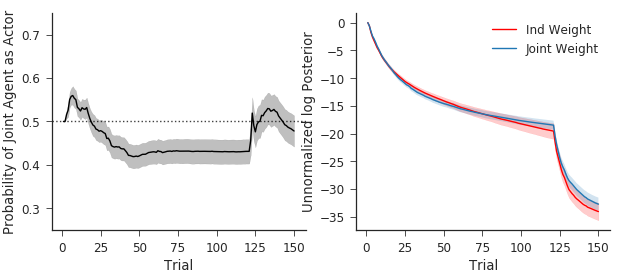

In [16]:
from matplotlib.ticker import NullFormatter


with sns.axes_style('ticks'):

    df0 = results_wMeta[(results_wMeta['Steps Taken']==1) & 
                  (results_wMeta['Model'] == 'Meta')
                 ].copy()

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    ax = axes[0]
    x = range(1, int(df0['Trial Number'].max()) + 2)
    y = df0.groupby('Trial Number')['Joint Probability'].mean()
    y_err = df0.groupby('Trial Number')['Joint Probability'].std() / np.sqrt(n_sims)
    ax.plot(x, y, 'k-')
    ax.fill_between(x, y-y_err, y+y_err, alpha=0.25, color='k')
    ax.set_ylabel('Probability of Joint Agent as Actor')
    ax.set_xlabel('Trial')
    xlb, xub = ax.get_xlim()
    ax.plot([xlb, xub], [0.5, 0.5], 'k:', alpha=0.75)
    ax.set_xlim(xlb, xub)
    ax.set_ylim([0.25, 0.75])

    ax = axes[1]
    y = df0.groupby('Trial Number')['Ind Weight'].mean()
    y_err = df0.groupby('Trial Number')['Ind Weight'].std() / np.sqrt(n_sims)
    ax.plot(x, y, 'r-')
    ax.fill_between(x, y-y_err, y+y_err, alpha=0.2, color='r')

    y = df0.groupby('Trial Number')['Joint Weight'].mean()
    y_err = df0.groupby('Trial Number')['Joint Weight'].std() / np.sqrt(n_sims)
    ax.plot(x, y, '-')
    ax.fill_between(x, y-y_err, y+y_err, alpha=0.2)
    plt.legend(loc='best')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Unnormalized log Posterior')    
    ax.set_xlim(xlb, xub)

    plt.subplots_adjust(hspace=0.3)
    sns.despine()
    plt.savefig('Exp1_fig3.png', dpi=300)

In [20]:
results_wMeta['Training'] = results_wMeta.Context < 5
results_wMeta[results_wMeta['In Goal']].groupby(['Training', 'Model']).mean()

Acc   Context  Goal KL Divergence  In Goal  \
Training Model                                                          
False    Flat         0.854333  6.166667            0.468281     True   
         Independent  0.807000  6.166667            1.661428     True   
         Joint        0.818667  6.166667            1.600524     True   
         Meta         0.814333  6.166667            1.640472     True   
True     Flat         0.953750  2.750000            0.184373     True   
         Independent  0.917917  2.750000            0.547331     True   
         Joint        0.941167  2.750000            0.563621     True   
         Meta         0.939583  2.750000            0.518924     True   

                      Ind Weight  Iteration  Joint Probability  Joint Weight  \
Training Model                                                                 
False    Flat                NaN       49.5                NaN           NaN   
         Independent         NaN       49.5                NaN           NaN   
         Joint               NaN       49.5                NaN           NaN   
         Meta         -30.651810       49.5           0.502801    -29.219033   
True     Flat                NaN       49.5                NaN           NaN   
         Independent         NaN       49.5                NaN           NaN   
         Joint               NaN       49.5                NaN           NaN   
         Meta         -14.147898       49.5           0.450021    -14.104082   

                      Key-press  Map KL Divergence  Steps Taken  \
Training Model                                                    
False    Flat          3.506000           0.754247     9.938000   
         Independent   3.474333           0.201908     7.650000   
         Joint         3.504000           0.424904     8.630667   
         Meta          3.499333           0.313485     8.299333   
True     Flat          3.504667           0.243220     7.372250   
         Independent   3.512833           0.163467     7.260500   
         Joint         3.512167           0.180621     7.198417   
         Meta          3.506167           0.175798     7.203583   

                      Times Seen Context  Trial Number  
Training Model                                          
False    Flat                   4.666667         134.5  
         Independent            4.666667         134.5  
         Joint                  4.666667         134.5  
         Meta                   4.666667         134.5  
True     Flat                  16.333333          59.5  
         Independent           16.333333          59.5  
         Joint                 16.333333          59.5  
         Meta                  16.333333          59.5

In [23]:
results_wMeta[results_wMeta['In Goal']].groupby(['Model']).mean()

,Acc,Context,Goal KL Divergence,In Goal,Ind Weight,Iteration,Joint Probability,Joint Weight,Key-press,Map KL Divergence,Steps Taken,Times Seen Context,Training,Trial Number
Model,,,,,,,,,,,,,,
Flat,0.933867,3.433333,0.241155,1.0,NaN,49.5,NaN,NaN,3.504933,0.345425,7.885400,14.0,0.8,74.5
Independent,0.895733,3.433333,0.770150,1.0,NaN,49.5,NaN,NaN,3.505133,0.171155,7.338400,14.0,0.8,74.5
Joint,0.916667,3.433333,0.771002,1.0,NaN,49.5,NaN,NaN,3.510533,0.229477,7.484867,14.0,0.8,74.5
Meta,0.914533,3.433333,0.743234,1.0,-17.44868,49.5,0.460577,-17.127072,3.504800,0.203336,7.422733,14.0,0.8,74.5
